In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import time

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Save off the model/scaler
import pickle

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../Resources/train_cleaned.csv")
print(df.shape)
df.head()

(103594, 24)


,id,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


### Initial Pre-processing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103594 entries, 0 to 103593
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103594 non-null  int64  
 1   gender                             103594 non-null  object 
 2   customer_type                      103594 non-null  object 
 3   age                                103594 non-null  int64  
 4   type_of_travel                     103594 non-null  object 
 5   travel_class                       103594 non-null  object 
 6   flight_distance                    103594 non-null  int64  
 7   inflight_wifi_service              103594 non-null  int64  
 8   departure_arrival_time_convenient  103594 non-null  int64  
 9   ease_of_online_booking             103594 non-null  int64  
 10  gate_location                      103594 non-null  int64  
 11  food_and_drink                     1035

In [4]:
df.columns

Index(['id', 'gender', 'customer_type', 'age', 'type_of_travel',
       'travel_class', 'flight_distance', 'inflight_wifi_service',
       'departure_arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes',
       'satisfaction'],
      dtype='object')

In [5]:
# Feature Engineering
# Changing these rankings to String values since they are categorical rather than numeric
# Help from: https://stackoverflow.com/a/70079246
df = df.astype({
    'inflight_wifi_service': 'str',
    'departure_arrival_time_convenient': 'str', 
    'ease_of_online_booking': 'str',
    'gate_location': 'str', 
    'food_and_drink': 'str', 
    'online_boarding': 'str', 
    'seat_comfort': 'str',
    'inflight_entertainment': 'str', 
    'on_board_service': 'str', 
    'leg_room_service': 'str',
    'baggage_handling': 'str', 
    'checkin_service': 'str', 
    'inflight_service': 'str',
    'cleanliness': 'str'
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103594 entries, 0 to 103593
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103594 non-null  int64  
 1   gender                             103594 non-null  object 
 2   customer_type                      103594 non-null  object 
 3   age                                103594 non-null  int64  
 4   type_of_travel                     103594 non-null  object 
 5   travel_class                       103594 non-null  object 
 6   flight_distance                    103594 non-null  int64  
 7   inflight_wifi_service              103594 non-null  object 
 8   departure_arrival_time_convenient  103594 non-null  object 
 9   ease_of_online_booking             103594 non-null  object 
 10  gate_location                      103594 non-null  object 
 11  food_and_drink                     1035

In [6]:
# Drop the id column
df.drop(columns=['id'], inplace=True)

In [7]:
# Convert "Satisfaction" column into numeric values
df["satisfaction"] = df.satisfaction.apply(lambda x: 1 if x=="satisfied" else 0)

In [8]:
# Check value counts of categorical columns to see if any binning needs to occur
cols = ['gender', 'customer_type', 'type_of_travel', 'travel_class']

for col in cols:
 print(df[col].value_counts())

gender
Female    52576
Male      51018
Name: count, dtype: int64
customer_type
Loyal Customer       84662
disloyal Customer    18932
Name: count, dtype: int64
type_of_travel
Business travel    71465
Personal Travel    32129
Name: count, dtype: int64
travel_class
Business    49533
Eco         46593
Eco Plus     7468
Name: count, dtype: int64


No binning needs to occur

In [9]:
# Create copies of the initial dataframe
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()
df4 = df.copy()

### Classification Function

In [10]:
# Function for Classification
def classModel(model, X_train, X_test, y_train, y_test):
    """ 
    This function requires that the train-test split has already occurred and for a model to be initialized prior to the function being run.

    If the problem is a multi-class problem, the ROC Curve will break and the function cannot be used.

    Ex. `lr = LogisticRegression()`
    """
    # Fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Confusion Matrix: 
    {train_cf}
    
    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Confusion Matrix: 
    {test_cf}
    
    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    
    # Set figure size
    plt.figure(figsize=(6, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.3f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

### One-Hot Encoding w/ Ratings

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103594 entries, 0 to 103593
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             103594 non-null  object 
 1   customer_type                      103594 non-null  object 
 2   age                                103594 non-null  int64  
 3   type_of_travel                     103594 non-null  object 
 4   travel_class                       103594 non-null  object 
 5   flight_distance                    103594 non-null  int64  
 6   inflight_wifi_service              103594 non-null  object 
 7   departure_arrival_time_convenient  103594 non-null  object 
 8   ease_of_online_booking             103594 non-null  object 
 9   gate_location                      103594 non-null  object 
 10  food_and_drink                     103594 non-null  object 
 11  online_boarding                    1035

In [12]:
df1.columns

Index(['gender', 'customer_type', 'age', 'type_of_travel', 'travel_class',
       'flight_distance', 'inflight_wifi_service',
       'departure_arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes',
       'satisfaction'],
      dtype='object')

In [13]:
# Define Preprocessing Pipelines

# Define preprocessing for numeric features 
numeric_features = ['age', 'flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for the binary features 
binary_features = ['gender', 'customer_type', 'type_of_travel']
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('label', OrdinalEncoder())])  # Label encode for binary feature

# Define preprocessing for categorical features
categorical_features = ['inflight_wifi_service',
       'departure_arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'travel_class']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('binary', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)])

In [14]:
# Correlation Analysis 
# Use only preprocessing pipeline to transform the data
preprocessed_X_train = preprocessor.fit_transform(df1)

# Convert preprocessed data to a DataFrame
# Get the feature names after one-hot encoding
encoded_feature_names = (numeric_features + binary_features +
                         list(preprocessor.transformers_[2][1]['onehot'].get_feature_names_out(categorical_features)))

df_final = pd.DataFrame(preprocessed_X_train.toarray(), columns=encoded_feature_names)
df_final["satisfaction"] = df1.satisfaction.values
df_final.head()

,age,flight_distance,departure_delay_in_minutes,arrival_delay_in_minutes,gender,customer_type,type_of_travel,inflight_wifi_service_0,inflight_wifi_service_1,inflight_wifi_service_2,inflight_wifi_service_3,inflight_wifi_service_4,inflight_wifi_service_5,departure_arrival_time_convenient_0,departure_arrival_time_convenient_1,departure_arrival_time_convenient_2,departure_arrival_time_convenient_3,departure_arrival_time_convenient_4,departure_arrival_time_convenient_5,ease_of_online_booking_0,ease_of_online_booking_1,ease_of_online_booking_2,ease_of_online_booking_3,ease_of_online_booking_4,ease_of_online_booking_5,gate_location_0,gate_location_1,gate_location_2,gate_location_3,gate_location_4,gate_location_5,food_and_drink_0,food_and_drink_1,food_and_drink_2,food_and_drink_3,food_and_drink_4,food_and_drink_5,online_boarding_0,online_boarding_1,online_boarding_2,online_boarding_3,online_boarding_4,online_boarding_5,seat_comfort_0,seat_comfort_1,seat_comfort_2,seat_comfort_3,seat_comfort_4,seat_comfort_5,inflight_entertainment_0,inflight_entertainment_1,inflight_entertainment_2,inflight_entertainment_3,inflight_entertainment_4,inflight_entertainment_5,on_board_service_0,on_board_service_1,on_board_service_2,on_board_service_3,on_board_service_4,on_board_service_5,leg_room_service_0,leg_room_service_1,leg_room_service_2,leg_room_service_3,leg_room_service_4,leg_room_service_5,baggage_handling_1,baggage_handling_2,baggage_handling_3,baggage_handling_4,baggage_handling_5,checkin_service_0,checkin_service_1,checkin_service_2,checkin_service_3,checkin_service_4,checkin_service_5,inflight_service_0,inflight_service_1,inflight_service_2,inflight_service_3,inflight_service_4,inflight_service_5,cleanliness_0,cleanliness_1,cleanliness_2,cleanliness_3,cleanliness_4,cleanliness_5,travel_class_Business,travel_class_Eco,travel_class_Eco Plus,satisfaction
0,-1.745542,-0.731305,0.268966,0.072905,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,-0.951526,-0.956916,-0.360682,-0.237184,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-0.885358,-0.047454,-0.386917,-0.392229,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
3,-0.951526,-0.629028,-0.098328,-0.159662,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,1.430521,-0.977973,-0.386917,-0.392229,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1


In [15]:
df1.satisfaction.value_counts()

satisfaction
0    58697
1    44897
Name: count, dtype: int64

In [16]:
 # Step 1: Get the data (NOTE: this is the original dataframe, not the one used for the correlations)
X = df1.drop(columns=["satisfaction"])
y = df1.satisfaction

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
print(X_train.shape, X_test.shape)

(77695, 22) (25899, 22)


In [17]:
X_train.head()

,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes
11006,Female,Loyal Customer,45,Business travel,Business,462,2,3,2,2,5,4,4,5,5,5,5,5,5,5,0,0.0
63962,Male,Loyal Customer,61,Personal Travel,Eco,502,5,5,5,1,5,5,5,5,3,2,5,5,5,5,0,3.0
46735,Male,Loyal Customer,31,Business travel,Business,2914,4,4,4,4,4,4,4,4,4,3,5,5,4,4,42,20.0
52904,Male,Loyal Customer,17,Personal Travel,Eco,2227,1,1,1,2,5,1,5,5,1,5,1,2,2,5,52,49.0
73047,Female,Loyal Customer,14,Personal Travel,Business,590,4,2,4,3,1,4,1,1,2,5,3,1,3,1,0,0.0


TRAIN METRICS
    Confusion Matrix: 
    [[43496   526]
 [ 1517 32156]]
    
    AUC: 0.9980731911536586

    Classification Report:
                  precision    recall  f1-score   support

           0       0.97      0.99      0.98     44022
           1       0.98      0.95      0.97     33673

    accuracy                           0.97     77695
   macro avg       0.98      0.97      0.97     77695
weighted avg       0.97      0.97      0.97     77695

    
TEST METRICS
    Confusion Matrix: 
    [[14416   259]
 [  640 10584]]
    
    AUC: 0.9954630015262985

    Classification Report:
                  precision    recall  f1-score   support

           0       0.96      0.98      0.97     14675
           1       0.98      0.94      0.96     11224

    accuracy                           0.97     25899
   macro avg       0.97      0.96      0.96     25899
weighted avg       0.97      0.97      0.97     25899

    


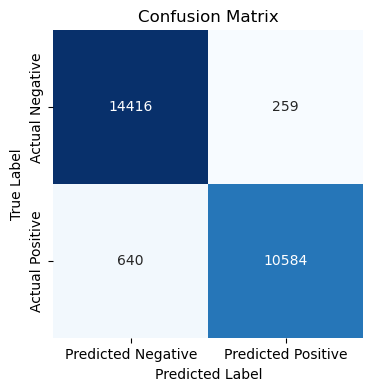

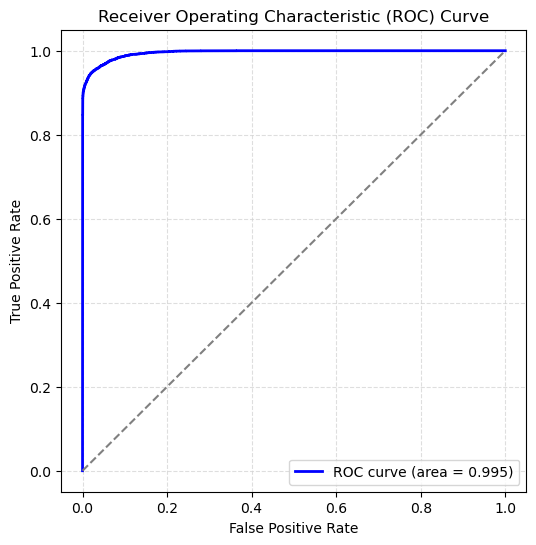

In [18]:
# Step 2: Init the Model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1, learning_rate=0.1, n_estimators=200))
])

# Do Machine Learning
classModel(lgbm, X_train, X_test, y_train, y_test)

In [19]:
fi = pd.DataFrame(list(zip(X.columns, lgbm.named_steps['classifier'].feature_importances_ / sum(lgbm.named_steps['classifier'].feature_importances_))), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,gender,0.099167
1,customer_type,0.094667
5,flight_distance,0.043167
3,type_of_travel,0.038667
11,online_boarding,0.035833
6,inflight_wifi_service,0.035667
2,age,0.034500
12,seat_comfort,0.025167
7,departure_arrival_time_convenient,0.021167
8,ease_of_online_booking,0.015167


In [20]:
# Step 2: Init the Model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1, learning_rate=0.1, n_estimators=200))
])

# Perform 5-fold cross-validation with accuracy scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='accuracy')
# Output the results
print(f"LGBM Cross-validation accuracy scores: {cv_scores}")
print(f"LGBM Mean accuracy: {np.mean(cv_scores):.4f}")

LGBM Cross-validation accuracy scores: [0.96346349 0.96520102 0.96240166 0.96573194 0.96616469]
LGBM Mean accuracy: 0.9646


In [21]:
# Step 2: Init the Model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1, learning_rate=0.1, n_estimators=200))
])

# Perform 5-fold cross-validation with accuracy scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='f1')
# Output the results
print(f"LGBM Cross-validation accuracy scores: {cv_scores}")
print(f"LGBM Mean accuracy: {np.mean(cv_scores):.4f}")

LGBM Cross-validation accuracy scores: [0.95705939 0.95918021 0.95591647 0.959682   0.96029453]
LGBM Mean accuracy: 0.9584


In [22]:
# Step 2: Init the Model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1, learning_rate=0.1, n_estimators=200))
])

# Perform 5-fold cross-validation with accuracy scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='precision')
# Output the results
print(f"LGBM Cross-validation accuracy scores: {cv_scores}")
print(f"LGBM Mean accuracy: {np.mean(cv_scores):.4f}")

LGBM Cross-validation accuracy scores: [0.97526012 0.97547213 0.97180992 0.97914253 0.97706316]
LGBM Mean accuracy: 0.9757


In [23]:
# Step 2: Init the Model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1, learning_rate=0.1, n_estimators=200))
])

# Perform 5-fold cross-validation with accuracy scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='recall')
# Output the results
print(f"LGBM Cross-validation accuracy scores: {cv_scores}")
print(f"LGBM Mean accuracy: {np.mean(cv_scores):.4f}")

LGBM Cross-validation accuracy scores: [0.93952556 0.94342354 0.94053452 0.94097996 0.94409177]
LGBM Mean accuracy: 0.9417


In [24]:
# Step 2: Init the Model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1, learning_rate=0.1, n_estimators=200))
])

# Perform 5-fold cross-validation with accuracy scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='roc_auc')
# Output the results
print(f"LGBM Cross-validation accuracy scores: {cv_scores}")
print(f"LGBM Mean accuracy: {np.mean(cv_scores):.4f}")

LGBM Cross-validation accuracy scores: [0.99490976 0.9954603  0.99528241 0.99530497 0.9954559 ]
LGBM Mean accuracy: 0.9953


#### Feature Importance

Based on Feature Importances, it looks like the LightGBM Model performed the best; it weighed almost all features evenly (and didn't weigh any 1 feature more than others (as was donne with gradient boost and XGBoost))

### Analysis